In [2]:
#code 5-16 VGG16 합성곱 기반 층 만들기
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150,150,3))

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-07-18 12:24:45.408464: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-18 12:24:45.408593: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
#code 5-17 사전 훈련된 합성곱 기반 층을 사용한 특성 추출하기

import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'dataset/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # 제너레이터는 루프 안에서 무한하게 데이터를 만들어내므로 모든 이미지를 한 번씩 처리하고 나면 중지합니다
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
1/1 [==============================] - 0s 140ms/step


2022-07-18 12:24:48.841224: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-18 12:24:48.903433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 12ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 12ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 12ms/step


In [4]:
train_features = np.reshape(train_features,(2000,4*4*512))
validation_features = np.reshape(validation_features,(1000,4*4*512))
test_features = np.reshape(test_features,(1000,4*4*512))

In [5]:
#code 5-18 완전 연결 분류기를 정의하고 훈련하기
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30


/opt/homebrew/Caskroom/miniforge/base/envs/conda_venv/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


  1/100 [..............................] - ETA: 32s - loss: 0.7399 - acc: 0.6000

2022-07-18 12:25:12.623466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 1s 8ms/step - loss: 0.7026 - acc: 0.6515 - val_loss: 0.4900 - val_acc: 0.7990
Epoch 2/30
  1/100 [..............................] - ETA: 0s - loss: 0.7704 - acc: 0.7500

2022-07-18 12:25:13.430962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 1s 7ms/step - loss: 0.4841 - acc: 0.8145 - val_loss: 0.4175 - val_acc: 0.8090
Epoch 3/30
100/100 [==============================] - 1s 7ms/step - loss: 0.4242 - acc: 0.8450 - val_loss: 0.3712 - val_acc: 0.8450
Epoch 4/30
100/100 [==============================] - 1s 7ms/step - loss: 0.3657 - acc: 0.8460 - val_loss: 0.3691 - val_acc: 0.8270
Epoch 5/30
100/100 [==============================] - 1s 7ms/step - loss: 0.3384 - acc: 0.8645 - val_loss: 0.3383 - val_acc: 0.8480
Epoch 6/30
100/100 [==============================] - 1s 7ms/step - loss: 0.3145 - acc: 0.8760 - val_loss: 0.3071 - val_acc: 0.8770
Epoch 7/30
100/100 [==============================] - 1s 7ms/step - loss: 0.2953 - acc: 0.8865 - val_loss: 0.3097 - val_acc: 0.8700
Epoch 8/30
100/100 [==============================] - 1s 7ms/step - loss: 0.2819 - acc: 0.8910 - val_loss: 0.2840 - val_acc: 0.8890
Epoch 9/30
100/100 [==============================] - 1s 7ms/step - loss: 0.2706 - acc:

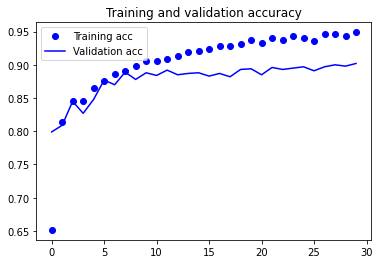

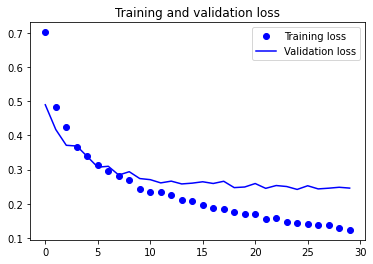

In [6]:
#code 5-19 결과 그래프 그리기
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [7]:
# code 5-20 합성곱 기반 층 위에 완전 연결 분류기 추가하기
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

In [8]:
print('conv_base를 동결하기 전 훈련되는 가중치의 수:', 
      len(model.trainable_weights))

conv_base를 동결하기 전 훈련되는 가중치의 수: 30


In [9]:
conv_base.trainable = False

In [10]:
print('conv_base를 동결한 후 훈련되는 가중치의 수:', 
      len(model.trainable_weights))

conv_base를 동결한 후 훈련되는 가중치의 수: 4


In [12]:
#code 5-21 동결된 합성곱 기반 층과 함께 모델을 엔드-투엔드로 훈련하기
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')

# 검증 데이터는 증식되어서는 안 됩니다!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지의 크기를 150 × 150로 변경합니다
        target_size=(150, 150),
        batch_size=20,
        # binary_crossentropy 손실을 사용하므로 이진 레이블이 필요합니다
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [13]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/30


/var/folders/r1/58cpj4hx7j75vx_3j1y6vpvw0000gn/T/ipykernel_46938/1576760166.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(
2022-07-18 12:27:14.657799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-18 12:27:22.406175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


100/100 - 12s - loss: 0.5623 - acc: 0.7265 - val_loss: 0.4376 - val_acc: 0.8360 - 12s/epoch - 118ms/step
Epoch 2/30
100/100 - 11s - loss: 0.4271 - acc: 0.8285 - val_loss: 0.3599 - val_acc: 0.8600 - 11s/epoch - 112ms/step
Epoch 3/30
100/100 - 11s - loss: 0.3658 - acc: 0.8465 - val_loss: 0.3138 - val_acc: 0.8760 - 11s/epoch - 110ms/step
Epoch 4/30
100/100 - 11s - loss: 0.3339 - acc: 0.8610 - val_loss: 0.2922 - val_acc: 0.8860 - 11s/epoch - 109ms/step
Epoch 5/30
100/100 - 11s - loss: 0.3111 - acc: 0.8775 - val_loss: 0.2828 - val_acc: 0.8820 - 11s/epoch - 109ms/step
Epoch 6/30
100/100 - 11s - loss: 0.2950 - acc: 0.8765 - val_loss: 0.2698 - val_acc: 0.8870 - 11s/epoch - 109ms/step
Epoch 7/30
100/100 - 11s - loss: 0.2862 - acc: 0.8805 - val_loss: 0.2610 - val_acc: 0.8900 - 11s/epoch - 109ms/step
Epoch 8/30
100/100 - 11s - loss: 0.2745 - acc: 0.8885 - val_loss: 0.2610 - val_acc: 0.8890 - 11s/epoch - 109ms/step
Epoch 9/30
100/100 - 11s - loss: 0.2641 - acc: 0.8990 - val_loss: 0.2498 - val_acc:

In [ ]:
model.save('cats_and_dogs_small_3.h5')

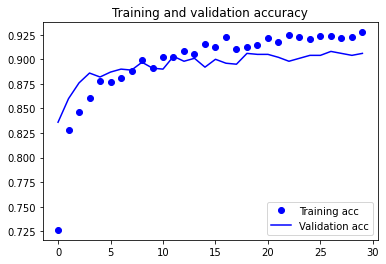

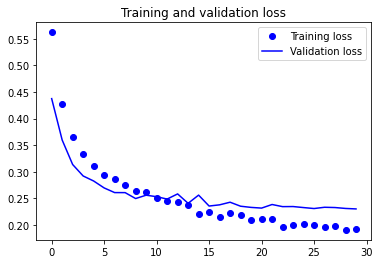

In [14]:

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [15]:
#code 5-22 특정 층까지 모든 층 동결하기
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [16]:
#code 5-23 모델 미세 조정하기
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100


/opt/homebrew/Caskroom/miniforge/base/envs/conda_venv/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
/var/folders/r1/58cpj4hx7j75vx_3j1y6vpvw0000gn/T/ipykernel_46938/511509295.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(
2022-07-18 12:41:05.256520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - ETA: 0s - loss: 0.2004 - acc: 0.9165

2022-07-18 12:41:15.182017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 14s 131ms/step - loss: 0.2004 - acc: 0.9165 - val_loss: 0.2208 - val_acc: 0.9150
Epoch 2/100
100/100 [==============================] - 13s 129ms/step - loss: 0.1570 - acc: 0.9385 - val_loss: 0.2149 - val_acc: 0.9120
Epoch 3/100
100/100 [==============================] - 13s 128ms/step - loss: 0.1444 - acc: 0.9435 - val_loss: 0.2138 - val_acc: 0.9210
Epoch 4/100
100/100 [==============================] - 13s 127ms/step - loss: 0.1272 - acc: 0.9535 - val_loss: 0.2100 - val_acc: 0.9160
Epoch 5/100
100/100 [==============================] - 13s 127ms/step - loss: 0.1133 - acc: 0.9535 - val_loss: 0.2142 - val_acc: 0.9170
Epoch 6/100
100/100 [==============================] - 13s 128ms/step - loss: 0.0976 - acc: 0.9635 - val_loss: 0.2243 - val_acc: 0.9240
Epoch 7/100
100/100 [==============================] - 13s 130ms/step - loss: 0.0802 - acc: 0.9690 - val_loss: 0.2021 - val_acc: 0.9320
Epoch 8/100
100/100 [==============================] - 13s 1

KeyboardInterrupt: 

In [17]:
model.save('cats_and_dogs_small_4.h5')

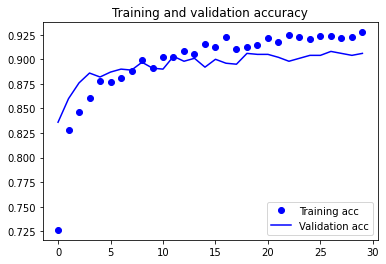

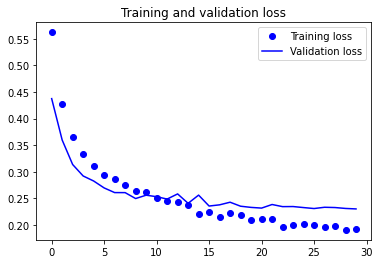

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

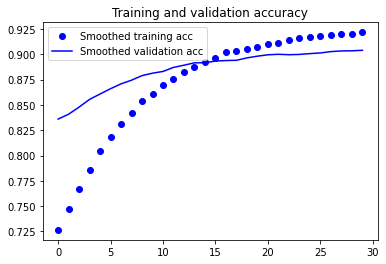

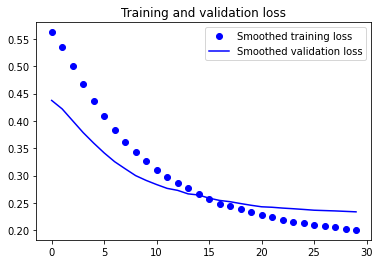

In [19]:
#code 5-24 부드러운 그래프 그리기
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()